# RiceRLE Codex Prototype

Install libraries

In [1]:
%pip install tabulate matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Import libraries

In [1]:
import os
import struct
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
import tabulate

c:\Users\j\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Rice encoding and decoding functions


This section explores Rice encoding, a technique characterized by its adjustable parameter, k. The code utilizes specialized functions: rice_encode() for encoding messages and rice_decode() for decoding them. A crucial aspect is verifying the implementation's accuracy. Messages are encoded and decoded using the same k value to ensure the original message remains unchanged. Additionally, the application is tested for robustness against modified messages with appended zeros or ones at the beginning.
The application also includes helper functions: bits_to_bytes() and bytes_to_bits(). These functions convert between lists of numbers and strings of bits, and vice versa. They have been rigorously tested to confirm their reliability in data conversion without information loss.


Another valuable feature is the is_files_equal() function. It performs a bit-by-bit comparison of two files to determine if they are identical. Testing has shown its effectiveness in correctly identifying both matching and distinct files.
Encoding and Decoding Process
The encoding process reads an input file byte by byte. Each byte is Rice encoded, and the encoded messages are combined into a single string. This string is then converted back into bytes and saved to an output file. The decoding process essentially reverses these steps, ensuring accurate retrieval and storage of the decoded messages.


ALL THE FILES THAT ARE GONNA BE DECODE OR ENCODE ARE GOING TO THE FOLDER 

ENC_and_DEC_files

In [2]:
folderpath= "Files/"
output_folder = "ENC_and_DEC_files/"

In [3]:
def decodeRice(code, encodeParamK) -> int:
    """
    Rice decode a code with parameter encodeParamK.

    Input:
        code: the Rice code to be decoded
        encodeParamK: the parameter of the Rice code (encodeParamK >= 0)
    
    The idea is to find the first 0 in the code. The currentNumber of 1s before the 0 is the riceQuotientValue,
    and the encodeParamK binaryBits after the 0 is the riceRemainder.
    """
    riceQuotientValue = code.find('0')
    riceRemainder = int(code[riceQuotientValue + 1:riceQuotientValue + 1 + encodeParamK], 2)
    return (riceQuotientValue << encodeParamK) + riceRemainder

In [4]:
def encodeRice(currentNumber, encodeParamK) -> str:
    """
    Rice encode a currentNumber loopCounterN with parameter encodeParamK.

    Input:
        currentNumber: the currentNumber to be encoded
        encodeParamK: the parameter of the Rice code (encodeParamK >= 0)

    The idea is to split the currentNumber into two parts: the riceQuotientValue and the riceRemainder.
    The riceQuotientValue is encoded as a unary currentNumber, and the riceRemainder is encoded as a binary currentNumber.
    """
    riceQuotientValue = currentNumber >> encodeParamK
    riceRemainder = currentNumber & ((1 << encodeParamK) - 1)

    return '1' * riceQuotientValue + '0' + format(riceRemainder, '0' + str(encodeParamK) + 'b')

Test encode and decode functions:

In [5]:
assert decodeRice(encodeRice(100, 3), 3) == 100

Should also work with any number of zeros or ones padded to the right:

In [6]:
assert decodeRice(encodeRice(100, 3).ljust(100, '0'), 3) == 100
assert decodeRice(encodeRice(100, 3).ljust(100, '1'), 3) == 100

## Helper functions

In [7]:
def filesEqualityCheck(file_1:str, file_2:str) -> bool:
    """
    Check if two files are equal.
    """
    with open(file_1, 'rb') as f1, open(file_2, 'rb') as f2:
        return f1.read() == f2.read()

In [8]:
def bytesToBinaryConverter(byte_data:bytearray) -> str:
    """
    Convert a bytes object to a string of binaryBits.
    """
    return ''.join(format(singleByte, '08b') for singleByte in byte_data)

In [9]:
def binaryToBytesConverter(binaryString:str) -> bytes:
    """
    Convert a string of binaryBits to a bytes object.
    """
    binaryPadded = binaryString + '0' * ((8 - len(binaryString) % 8) % 8)
    return bytes(int(binaryPadded[loopIndex:loopIndex+8], 2) for loopIndex in range(0, len(binaryPadded), 8))

Test helper functions:

In [10]:
currentNumber = 100500

# Create a bit string from the current number.
binaryString = bin(currentNumber)[2:]

# Append padding to the bit string to achieve the required length.
binaryPadding = (8 - len(binaryString) % 8) % 8
binaryString = binaryString.zfill(len(binaryString) + binaryPadding)

binaryBits = bytesToBinaryConverter(binaryToBytesConverter(binaryString))

assert int(binaryBits, 2) == currentNumber

In [11]:
assert filesEqualityCheck(folderpath + "Sound1.wav", folderpath + "Sound2.wav") == False
assert filesEqualityCheck(folderpath + "Sound1.wav", folderpath + "Sound1.wav")

## Encode a file

The encoding process reads an input file byte by byte. Each byte is Rice encoded, and the encoded messages are combined into a single string. This string is then converted back into bytes and saved to an output file. The decoding process essentially reverses these steps, ensuring accurate retrieval and storage of the decoded messages.

In [12]:
def riceEncodedFilePath(input_file, output_file, encodeParamK):
    """
    Encode a currentFile using Rice encodingMethod with parameter encodeParamK.
    """

# Load the specified file.
    with open(input_file, 'rb') as currentFile:
        rawInputData = currentFile.read()

# Transform the raw input data into a bit string using Rice encoding.
    binaryString = ''.join([encodeRice(loopCounterN, encodeParamK) for loopCounterN in rawInputData])

# Append padding to the bit string's right side to ensure it has a length divisible by 8, making it convertible to bytes.
# Write the resulting data to the specified file.
    binaryPadding = (8 - len(binaryString) % 8) % 8
    binaryString = binaryString.ljust(len(binaryString) + binaryPadding, '1')

    riceEncodedData = binaryToBytesConverter(binaryString)

# Load data from the specified file.
    with open(output_file, 'wb') as currentFile:
        currentFile.write(riceEncodedData)

In [13]:
def riceDecodedFilePath(input_file, output_file, encodeParamK):
    """
    Decode a currentFile using Rice encodingMethod with parameter encodeParamK.
    """
# Transform the raw input data into a bit string.
    with open(input_file, 'rb') as currentFile:
        rawInputData = currentFile.read()

# Perform decoding.
    binaryString = bytesToBinaryConverter(rawInputData)

# Locate the next '0' in the bit string.
    riceDecodedData = []
    loopStartIndex = 0
    while loopStartIndex < len(binaryString):
# Check for the absence of '0' or if there are not enough bits following the '0' for encoding parameters.
        riceQuotient = binaryString.find('0', loopStartIndex)

# Decode a section of the bit string using Rice encoding.
        if riceQuotient == -1 or riceQuotient + encodeParamK >= len(binaryString):
            break

# Advance the loop start index to the next section.
        currentValue = decodeRice(binaryString[loopStartIndex:riceQuotient + encodeParamK + 1], encodeParamK)

        riceDecodedData.append(currentValue)

# Write the decoded data to the specified file.
        loopStartIndex = riceQuotient + encodeParamK + 1

# Perform encoding on the file with a parameter of 4.
    with open(output_file, 'wb') as currentFile:
        currentFile.write(bytes(riceDecodedData))

## Processing

In [14]:
filePaths = [folderpath + "Sound1.wav", folderpath + "Sound2.wav"]

tableContent = []

for currentFile in filePaths:
    directory, fileNameWithExt = os.path.split(currentFile)
    sampleFileName = os.path.splitext(os.path.basename(currentFile))[0]

    originalDataSize = os.path.getsize(currentFile)
    genericOutputFileName = output_folder + sampleFileName +  '_Enc.enc'

# Perform decoding on the file.
    riceEncodedFilePath(currentFile, genericOutputFileName, 4)
    sizeAfterEncodingK4 = os.path.getsize(genericOutputFileName)

# Verify the decoded file matches the original.
    riceDecodedFileName = output_folder + sampleFileName +   '_Enc_Dec.wav'
    riceDecodedFilePath(genericOutputFileName, riceDecodedFileName, 4)

# Encode the file with a parameter of 2.
    assert filesEqualityCheck(currentFile, riceDecodedFileName)

# Decode the file.
    riceEncodedFilePath(currentFile, genericOutputFileName, 2)
    sizeAfterEncodingK2 = os.path.getsize(genericOutputFileName)

# Ensure the decoded file matches the original.
    riceDecodedFileName = output_folder + sampleFileName +   '_Enc_Dec.wav'
    riceDecodedFilePath(genericOutputFileName, riceDecodedFileName, 2)

# Calculate and compare compression ratios for parameters 4 and 2.
    assert filesEqualityCheck(currentFile, riceDecodedFileName)

# Record the results of the function.
    compressionRateK4 = (1 - sizeAfterEncodingK4 / originalDataSize) * 100
    compressionRateK2 = (1 - sizeAfterEncodingK2 / originalDataSize) * 100

# Generate a sequence of numbers from 2 to 21.
    tableContent.append([currentFile, originalDataSize, sizeAfterEncodingK4, sizeAfterEncodingK2, compressionRateK4, compressionRateK2])

## Display the results

The results with the proposed in the task description k parameters are the following:

In [15]:
dataTable = tabulate.tabulate(tableContent,  tablefmt='html', headers=["", "Original size", "Rice (riceParamK = 4 binaryBits)", "Rice (riceParamK = 2 binaryBits)", "% Compression (riceParamK = 4 binaryBits)", "% Compression (riceParamK = 2 binaryBits)"])
dataTable

,Original size,Rice (riceParamK = 4 binaryBits),Rice (riceParamK = 2 binaryBits),% Compression (riceParamK = 4 binaryBits),% Compression (riceParamK = 2 binaryBits)
Files/Sound1.wav,1002088,1516265,4115718,-51.3106,-310.714
Files/Sound2.wav,1008044,1575347,4348595,-56.2776,-331.389


## Impact of the k Parameter

An important observation is that the encoded file size increases with a smaller k value. For instance, with k set to 4 bits, the file size grows roughly 1.5 times the original size. At k equal to 2 bits, the size quadruples. The k parameter significantly affects how the input data is divided into unary and binary parts within the code words. A larger k allocates more bits to the binary part. The optimal k value depends on the statistical properties of the input data, such as the prevalence of zeros and the distribution's variance. Experimenting with various k values is recommended to find the most suitable parameter for a given dataset, aiming to optimize encoding efficiency as demonstrated in the provided table.

## Further development

For further development, I would like to explore the influence of the k parameter on the compression ratio using Rice coding. The experiment involved adjusting k values and observing the resulting compression ratios, which are illustrated in a detailed plot.

In [16]:
# Encode the file using the given parameter.
kVariants = range(2, 22)

functionResults = []

for encodeParamK in tqdm(kVariants):
# Determine the compression ratio.
    genericOutputFileName = output_folder + "Sound1_Enc.enc"
    riceEncodedFilePath(folderpath + "Sound1.wav", genericOutputFileName, encodeParamK)
    encodedDataSize = os.path.getsize(genericOutputFileName)

# Document the results of the function.
    riceCompressionRate = (1 - encodedDataSize / originalDataSize) * 100

# Calculate the count of 2-byte numbers within a byte sequence.
    functionResults.append([encodeParamK, riceCompressionRate])

functionResults = np.array(functionResults)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Plot the results:

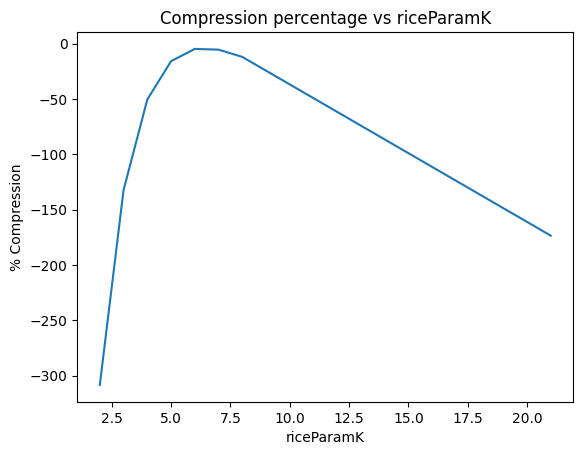

In [17]:
plt.title('Compression percentage vs riceParamK')
plt.xlabel('riceParamK')
plt.ylabel('% Compression')
plt.plot(functionResults[:, 0], functionResults[:, 1])
plt.show()

In [18]:
functionResults[np.argmax(functionResults[:, 1])]

array([ 6.        , -4.64761459])

As observed, the best performance was achieved at k=6. However, the compression ratio of -4.6% indicates a slight increase in file size after compression. This highlights a limitation of Rice coding, particularly its inefficiency in compressing files without a dominance of smaller values. Rice coding inherently benefits datasets with more frequent occurrences of smaller values. Further analysis revealed that the data distribution resembled the original dataset, characterized by extended sequences of zeros and ones.

In [19]:
with open(folderpath + "Sound1.wav", 'rb') as currentFile:
    fileContents = currentFile.read()

In [20]:
np.array(list(fileContents)).std()

112.07312533849903

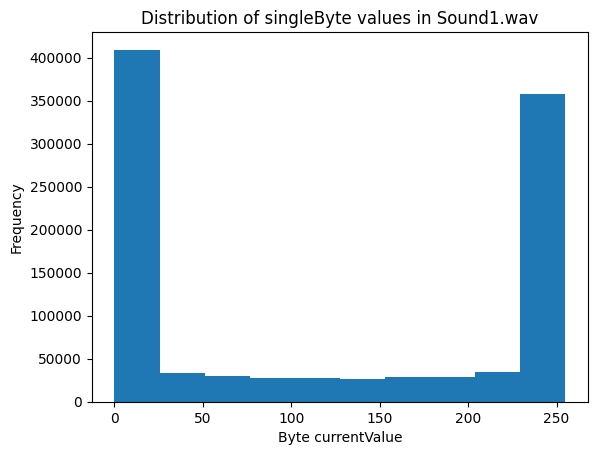

In [21]:
plt.title('Distribution of singleByte values in Sound1.wav')
plt.hist(list(fileContents))
plt.ylabel('Frequency')
plt.xlabel('Byte currentValue')
plt.show()

Analyzing the data distribution reveals a relatively even spread of large and small values, with few values falling in the middle range. This distribution unfortunately limits the effectiveness of Rice coding for this particular dataset. To improve its efficiency, we need to shift the distribution towards a more skewed pattern. One potential approach involves combining consecutive values and observing if it influences the distribution in a way that benefits Rice coding.

In [22]:
# Convert the bytes to a list of 2-byte numbers.
totalNumbers = len(fileContents) // 2

# Iterate over the numbers, counting consecutive occurrences.
dualByteNumbers = struct.unpack(f'{totalNumbers}H', fileContents)

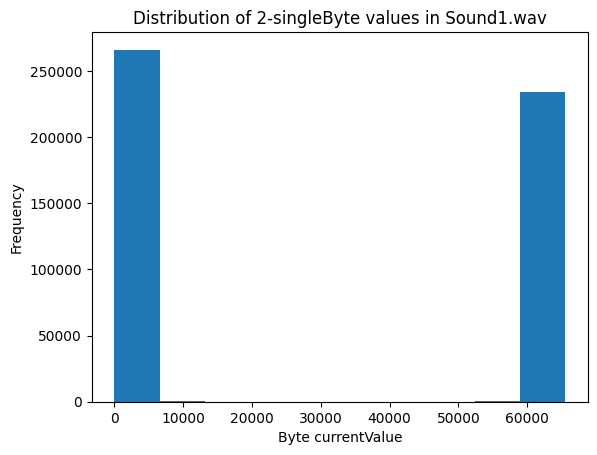

In [23]:
plt.title('Distribution of 2-singleByte values in Sound1.wav')
plt.hist(dualByteNumbers)
plt.ylabel('Frequency')
plt.xlabel('Byte currentValue')
plt.show()

The encoded data's distribution closely mirrors the original data, likely due to the presence of extended sequences of zeros and ones in the original file. In such scenarios, combining Rice coding with Run-Length Encoding (RLE) could be highly effective. Let's explore how integrating RLE with Rice coding performs.

## Run-Length Encoding (RLE) encoding and decoding functions

In [24]:
def encodeRLE(rawData):
    """
    Encode a list of numbers using RLE.
    """
    encodingMethod = []
    loopIndex = 0
# Load the file for reading.
# Apply Run-Length Encoding (RLE) to the input data.
    while loopIndex < len(rawData):
        loopCounter = 1
        while loopIndex + 1 < len(rawData) and loopIndex < 255 and rawData[loopIndex] == rawData[loopIndex + 1]:
            loopIndex += 1
            loopCounter += 1
        encodingMethod.append(rawData[loopIndex])
        encodingMethod.append(loopCounter)
        loopIndex += 1
    return encodingMethod

def decodeRLE(encodingMethod):
    """
    Decode a list of numbers using RLE.
    """
    rawData = []
    for (currentValue, loopCounter) in np.array(encodingMethod).reshape((-1, 2)):
        rawData.extend([currentValue] * loopCounter)
    return rawData

Tests:

In [25]:
rawData = [1,1,1,1,1,1,1,1,0,0,0,0,0,0]
assert decodeRLE(encodeRLE(rawData)) == rawData

## Function to encode a file with RLE

In [26]:
def rleEncodedFilePath(input_file, output_file):
    """
    Encode a currentFile using RLE.
    """

# Save the RLE-encoded data to a file.
    with open(input_file, 'rb') as currentFile:
        rawInputData = currentFile.read()
    
# Load the RLE-encoded file.
    riceEncodedData = encodeRLE(rawInputData)

# Decode the RLE-encoded data.
    with open(output_file, 'wb') as currentFile:
        currentFile.write(bytes(riceEncodedData))

In [27]:
def rleDecodedFilePath(input_file, output_file):
    """
    Decode a currentFile using  RLE.
    """
# Save the decoded data to a file.
    with open(input_file, 'rb') as currentFile:
        rawInputData = currentFile.read()
    
# Specify the use of a '.rle' extension for RLE-encoded files.
    riceDecodedData = decodeRLE(list(rawInputData))

# Encode the file.
    with open(output_file, 'wb') as currentFile:
        currentFile.write(bytes(riceDecodedData))

In [28]:
filePaths = [folderpath + "Sound1.wav", folderpath + "Sound2.wav"]

tableContent = []

for currentFile in filePaths:
    sampleFileName = os.path.splitext(os.path.basename(currentFile))[0]
    print (sampleFileName)

# Decode the file.
    originalDataSize = os.path.getsize(currentFile)
    genericOutputFileName = output_folder + sampleFileName +  '_Enc.rle'

# Confirm the decoded file is identical to the original.
    rleEncodedFilePath(currentFile, genericOutputFileName)
    encodedDataSize = os.path.getsize(genericOutputFileName)

# Compute and compare compression ratios for parameters 4 and 2.
    riceDecodedFileName = output_folder + sampleFileName +  '_Enc_Dec.wav'
    rleDecodedFilePath(genericOutputFileName, riceDecodedFileName)

# Log the results of the operation.
    assert filesEqualityCheck(currentFile, riceDecodedFileName)

# Set the Rice encoding parameter to 6.
    riceCompressionRate = (1 - encodedDataSize / originalDataSize) * 100

# Indicate the use of a '.rle' extension for RLE-encoded files.
    tableContent.append([currentFile, originalDataSize, encodedDataSize, riceCompressionRate])

Sound1
Sound2


In [29]:
dataTable = tabulate.tabulate(tableContent,  tablefmt='html', headers=["", "Original size", "RLE Encoded", "% Compression",])
dataTable

,Original size,RLE Encoded,% Compression
Files/Sound1.wav,1002088,2004092,-99.9916
Files/Sound2.wav,1008044,2016080,-99.9992


Conclusion: the file size doubled by an RLE encoding. Let's try to combine RLE with Rice coding.

## The combination of Rice and RLE

In [30]:
filePaths = [folderpath +"Sound1.wav", folderpath + "Sound2.wav"]

tableContent = []

# Encode the file.
encodeParamK = 6 

for currentFile in filePaths:
    sampleFileName = os.path.splitext(os.path.basename(currentFile))[0]

# Decode the file.
    originalDataSize = os.path.getsize(currentFile)
    rleOutputFileName = output_folder + sampleFileName +   '_Enc.rle'
    riceOutputFileName = output_folder + sampleFileName +  '_Enc.rle.enc'

# Confirm the decoded file matches the original.
    rleEncodedFilePath(currentFile, rleOutputFileName)
    riceEncodedFilePath(rleOutputFileName, riceOutputFileName, encodeParamK)
    encodedDataSize = os.path.getsize(riceOutputFileName)

# Calculate and compare compression ratios for parameters 4 and 2.
    riceDecodedFileName = output_folder + sampleFileName +   '_Enc_Dec.wav'
    rleDecodedFileName = output_folder + sampleFileName +   '_Enc_Dec.wav.rle'
    riceDecodedFilePath(riceOutputFileName, rleDecodedFileName, encodeParamK)
    rleDecodedFilePath(rleDecodedFileName, riceDecodedFileName)

# Record the operational results.
    assert filesEqualityCheck(currentFile, riceDecodedFileName)

    riceCompressionRate = (1 - encodedDataSize / originalDataSize) * 100

    tableContent.append([currentFile, originalDataSize, encodedDataSize, riceCompressionRate])

In [31]:
dataTable = tabulate.tabulate(tableContent,  tablefmt='html', headers=["", "Original size", "RLE+Rice Encoded", "% Compression",])
dataTable

,Original size,RLE+Rice Encoded,% Compression
Files/Sound1.wav,1002088,1931642,-92.7617
Files/Sound2.wav,1008044,1953034,-93.7449


 The exploration concludes by examining the standard deviation of the "Sound1.wav" file, which is 112. This significant variance in data values suggests that segmenting the original file could pave the way for optimizing compression algorithm parameters specific to each segment. For Rice coding, this could involve employing different k values tailored to distinct file chunks, aiming for improved compression efficiency.
